# A3C

In [1]:
import gym
import sys
sys.path.insert(0,'../')
from preprocessings.atari_preprocessing import AtariPreprocess
import matplotlib.pyplot as plt
from paralleling.parallel import EnvBatch
from buffers.frame_buffer import FrameBuffer
import pandas as pd

In [2]:
def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = AtariPreprocess(env,img_size=(42,42,1), crop_func=lambda x: x[60:-30, 5:, :])
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env


In [3]:
env = make_env()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

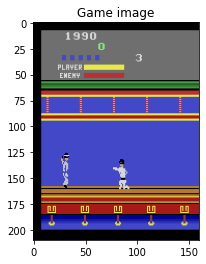

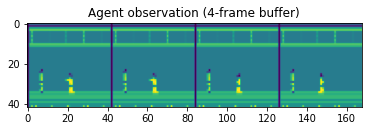

In [4]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0, 2, 1]).reshape([42,-1]))
plt.show()

# Model training

In [5]:
import multiprocessing
import threading
import tensorflow as tf
from IPython.display import display
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, Flatten, Dense
from tensorflow.keras.models import Sequential, Model

In [6]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()

        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [7]:
def update_target_graph(from_scope,to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

In [8]:
def ewma(x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values


In [9]:
class A2C:
    def __init__(self, name, state_shape, n_actions, trainer, sess,
                 gamma=0.99, alpha=0.001, beta=1, reuse=False):
        """A simple actor-critic agent"""
        self.trainer = trainer
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.n_actions = n_actions
        self.sess = sess
        self.eta = eta
        self.name = name
        with tf.variable_scope(self.name, reuse=reuse):
            input = Input(shape=state_shape)
            body = Sequential([
            Conv2D(filters=32, kernel_size=(3,3),strides=(2,2), activation='elu'),
            Conv2D(filters=32, kernel_size=(3,3),strides=(2,2), activation='elu'),
            Conv2D(filters=32, kernel_size=(3,3),strides=(2,2), activation='elu'),
            Flatten(),
            Dense(units=128,activation='elu')
            ])(input)
            logits = Dense(units=n_actions)(body)
            values = Dense(units=1)(body)
            self.model = Model(inputs=input, outputs=[logits, values])
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
            
        self.states_ph, self.next_states_ph, self.actions_ph, self.rewards_ph, self.is_done_ph = self.init_placeholders(state_shape)
        self.train_step, self.actor_loss, self.critic_loss, self.entropy = self.graph_flow()
        

    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        logits, state_values = self.model(state_t)
        state_values = tf.squeeze(state_values,axis=1)
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "Please return 2D TF tensor of logits [you got %s]." % repr(logits)
        assert tf.is_numeric_tensor(state_values) and state_values.shape.ndims == 1, \
            "Please return 1D TF tensor of state values [you got %s]." % repr(state_values)
        return logits, state_values
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        return self.sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])
    
    def init_placeholders(self,obs_shape):
        states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
        next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
        actions_ph = tf.placeholder('int32', (None,))
        rewards_ph = tf.placeholder('float32', (None,))
        is_done_ph = tf.placeholder('float32', (None,))
        return states_ph, next_states_ph, actions_ph, rewards_ph, is_done_ph
    
    def graph_flow(self):
        logits, state_values = self.symbolic_step(self.states_ph)
        next_logits, next_state_values = self.symbolic_step(self.next_states_ph)
        next_state_values = next_state_values * (1 - self.is_done_ph)
        probs = tf.nn.softmax(logits, axis=-1)            
        logprobs = tf.nn.log_softmax(logits, axis=-1)     
        logp_actions = tf.reduce_sum(logprobs * tf.one_hot(self.actions_ph, self.n_actions), axis=-1) 
        advantage = self.rewards_ph+self.gamma*next_state_values-state_values
        assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"
        entropy =  - tf.reduce_sum(probs*logprobs,axis=1)
        assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "
        target_state_values = self.rewards_ph+self.gamma*next_state_values
        actor_loss = -tf.reduce_mean(logp_actions * tf.stop_gradient(advantage), axis=0) - self.alpha * tf.reduce_mean(entropy, axis=0)
        critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2, axis=0)
        loss = actor_loss + self.beta*critic_loss
        
        local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.name)
        gradients = tf.gradients(loss,local_vars)

        global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
        apply_grads = self.trainer.apply_gradients(zip(gradients,global_vars))
        
        return apply_grads, actor_loss, critic_loss, entropy
    
    def train(self,batch_states,batch_actions,batch_next_states,batch_rewards,batch_done):
         feed_dict = {
            self.states_ph: batch_states,
            self.actions_ph: batch_actions,
            self.next_states_ph: batch_next_states,
            self.rewards_ph: batch_rewards,
            self.is_done_ph: batch_done,
        }
         _, entropy, actor_loss, critic_loss = self.sess.run([self.train_step, self.entropy, self.actor_loss,self.critic_loss], feed_dict)
         return entropy, actor_loss, critic_loss

In [10]:
class Worker:
    def __init__(self, train_env, test_env, name, trainer,sess, state_shape, n_actions,
                gamma=0.99, alpha=0.001, beta=1):
        self.train_env = train_env
        self.test_env = test_env
        self.name = 'worker_'+str(name)
        self.local_network = A2C(self.name, state_shape, n_actions, trainer,sess,
                 gamma=gamma, alpha=alpha, beta=beta)
        self.update_graph = update_target_graph('global',self.name)
        self.summary_writer = tf.summary.FileWriter("train_"+str(name))

        
    def train(self, num_steps=100000):
        entropy_history = []
        actor_history = []
        critic_history = []
        rewards_history = []
        batch_states = self.train_env.reset()
        counter = 0
        with sess.as_default() and sess.graph.as_default():
            for step in range(num_steps):
                agent_outputs = self.local_network.step(batch_states)
                batch_actions = self.local_network.sample_actions(agent_outputs)
                batch_next_states, batch_rewards, batch_done, _ = self.train_env.step(batch_actions)
                batch_rewards *= 0.01
                entropy, actor_loss, critic_loss = self.local_network.train(batch_states,batch_actions,batch_next_states,batch_rewards,batch_done)

                batch_states = batch_next_states
                
                if step % 500 == 0:
                    reward = np.mean(evaluate(self.local_network, self.test_env, n_games=3))
                    
                    summary = tf.Summary()
                    summary.value.add(tag='Perf/Reward', simple_value=float(reward))
                    summary.value.add(tag='Losses/Actor Loss', simple_value=float(np.mean(actor_loss)))
                    summary.value.add(tag='Losses/Critic Loss', simple_value=float(np.mean(critic_loss)))
                    summary.value.add(tag='Losses/Entropy', simple_value=float(np.mean(entropy)))
                    self.summary_writer.add_summary(summary, counter)
                    counter+=1
                sess.run(self.update_graph)



In [11]:
eta = 1e-4
num_steps = 10000
gamma=0.99
alpha = 0.01
beta = 1

In [12]:
tf.reset_default_graph()
import time
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    with tf.device("/cpu:0"): 
        trainer = tf.train.AdamOptimizer(learning_rate=eta)
        master_network = A2C('global',observation_shape,n_actions, trainer = trainer, sess=sess,
                            gamma=gamma, alpha=alpha, beta=beta)
        num_workers = multiprocessing.cpu_count() 
        workers = []
        for i in range(num_workers):
            workers.append(Worker(EnvBatch(make_env,10), make_env(), i, trainer, sess, observation_shape, n_actions,
                    gamma=gamma, alpha=alpha, beta=beta))
        saver = tf.train.Saver(max_to_keep=5)

    sess.run(tf.global_variables_initializer())
        
    worker_threads = []
    for worker in workers:
        worker_work = lambda: worker.train(num_steps)
        t = threading.Thread(target=(worker_work))
        t.start()
        time.sleep(0.5)
        worker_threads.append(t)
    coord.join(worker_threads)
    saver.save(sess, 'a3c_model')
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Testing agent performance

In [13]:
from IPython.display import clear_output


In [14]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    clear_output(wait=True)
    display(plt.gcf())

In [22]:
worker = workers[10]
best_network = worker.local_network

Sum of rewards : 36000.0


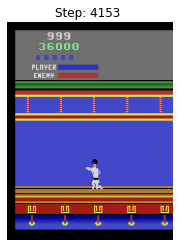

In [23]:
env = make_env()
steps = 10000
s = env.reset()
rewards = 0
last_info = None
with tf.Session() as sess:
    saver.restore(sess,'a3c_model')
    best_network.sess = sess
    for t in range(steps):
        show_state(env,t)
        env.render()
        a = best_network.sample_actions(best_network.step([s]))[0]
        next_s, r, done, info = env.step(a)
        rewards+=r
        s = next_s
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()
clear_output(wait=True)
print("Sum of rewards : {}".format(rewards))

In [31]:
with tf.Session() as sess:
    saver.restore(sess,'a3c_model')
    master_network.sess = sess
    reward = np.mean(evaluate(master_network, env, n_games=3))


INFO:tensorflow:Restoring parameters from a3c_model


In [32]:
print('Mean reward : {}'.format(reward))

Mean reward : 27066.666666666668
